In [1]:
import pandas as pd
import mysql
from connect import DatabaseConnector

# Total Views : from the Vendor Views logs Table We use the vendor_id to count the number views made

In [2]:
def get_vendor_Total_Views(vendor_id):
    
    db_connector = DatabaseConnector()  # Create an instance of DatabaseConnector
    # Connect to the database
    db_connector.connect_db()
    # Get the database connection
    connection = db_connector.get_connection()

    # If connection is not established, return
    if connection is None:
        print("No connection available to summarize the database.")
        return
    cursor = connection.cursor()

    try:
        # Execute the query to calculate the total count of the specified vendor_id
        query = f"""
            SELECT COUNT(*) AS count
            FROM vendor_view_logs
            WHERE vendor_id = %s
        """
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract count from the result tuple
        else:
            return 0  # If no rows are found, return count as 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [3]:
get_vendor_Total_Views(26)

Successfully connected to the database
Connection closed


6957

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def plot_vendor_comparison(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve vendor counts.")
        return

    cursor = connection.cursor()

    try:
        # Get count for the specified vendor_id and all vendors
        query = """
            SELECT vendor_id, COUNT(*) AS total_views
            FROM vendor_view_logs
            GROUP BY vendor_id
        """
        cursor.execute(query)
        results = cursor.fetchall()

        # Create a DataFrame from the results
        df = pd.DataFrame(results, columns=['vendor_id', 'total_views'])

        # Get count for the specified vendor_id
        specified_vendor_count = df[df['vendor_id'] == vendor_id]['total_views'].values[0]

        # Get the vendor_id with the highest count
        highest_vendor_count = df['total_views'].max()

        # Get ranks
        df['rank'] = df['total_views'].rank(method='min', ascending=False)
        specified_vendor_rank = df[df['vendor_id'] == vendor_id]['rank'].values[0]
        highest_vendor_rank = df[df['total_views'] == highest_vendor_count]['rank'].values[0]

        # Plotting
        plt.figure(figsize=(8, 6))
        bars = plt.bar(['Specified Vendor', 'Highest Vendor'], [specified_vendor_count, highest_vendor_count], color=['skyblue', 'orange'])
        plt.xlabel('Vendor')
        plt.ylabel('Total Views')
        plt.title('Comparison of Specified Vendor vs Highest Vendor')

        # Add rank numbers at the top of each bar
        plt.text(bars[0].get_x() + bars[0].get_width() / 2, bars[0].get_height(), f'Rank: {int(specified_vendor_rank)}', ha='center', va='bottom')
        plt.text(bars[1].get_x() + bars[1].get_width() / 2, bars[1].get_height(), f'Rank: {int(highest_vendor_rank)}', ha='center', va='bottom')

        plt.show()
    except mysql.connector.Error as e:
        print(f"Error: {e}")
    finally:
        cursor.close()
        db_connector.close_connection()

# We can ranke our vendor produt views with the highest views

Successfully connected to the database


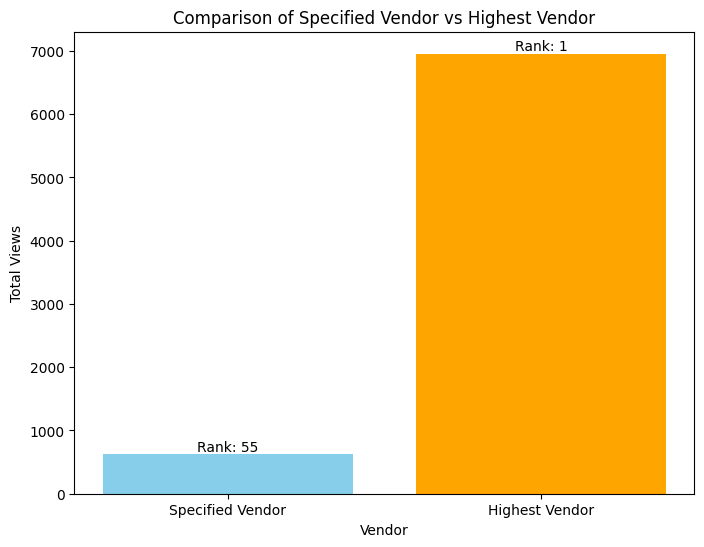

Connection closed


In [6]:
plot_vendor_comparison(268)

In [7]:
def is_vendor(user_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to check user type.")
        return False

    cursor = connection.cursor()

    try:
        # Query to check if the user is a vendor
        query = """
            SELECT type
            FROM users
            WHERE id = %s
        """
        cursor.execute(query, (user_id,))
        result = cursor.fetchone()

        if result and result[0] == 'vendor':
            return True
        else:
            return False
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return False
    finally:
        cursor.close()
        db_connector.close_connection()


# Example usage
user_id = 123  # Replace with the actual user ID
is_vendor_user = is_vendor(user_id)
print(f"Is the user with ID {user_id} a vendor? {is_vendor_user}")

Successfully connected to the database
Connection closed
Is the user with ID 123 a vendor? True


In [8]:
# Example usage
user_id = 26  # Replace with the actual user ID
is_vendor_user = is_vendor(user_id)
print(f"Is the user with ID {user_id} a vendor? {is_vendor_user}")

Successfully connected to the database
Connection closed
Is the user with ID 26 a vendor? True


# Unique Costomers Count

In [9]:
def get_unique_customers_count(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve unique customers count.")
        return None

    cursor = connection.cursor()

    try:
        # Query to get the number of unique customer_id for a given vendor_id
        query = """
            SELECT COUNT(DISTINCT buy_logs.user_id) AS unique_customers_count
            FROM vendors
            JOIN products ON vendors.user_id = products.user_id
            JOIN buy_logs ON products.id = buy_logs.product_id
            WHERE vendors.id = %s
        """
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract unique_customers_count from the result tuple
        else:
            return 0  # If no rows are found, return 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [12]:
# Example usage
vendor_id = 268  # Replace with the actual vendor ID
unique_customers_count = get_unique_customers_count(vendor_id)
print(f"Number of unique customers for vendor ID {vendor_id}: {unique_customers_count}")

Successfully connected to the database
Connection closed
Number of unique customers for vendor ID 268: 16


# Optimized Unique Costomers Count

In [13]:
def get_unique_customers_count(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve unique customers count.")
        return None

    cursor = connection.cursor()

    try:
        # Nested query to get the number of unique customer_id for a given vendor_id
        query = """
            SELECT COUNT(DISTINCT user_id) AS unique_customers_count
            FROM buy_logs
            WHERE product_id IN (
                SELECT id
                FROM products
                WHERE user_id = (
                    SELECT user_id
                    FROM vendors
                    WHERE id = %s
                )
            )
        """
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract unique_customers_count from the result tuple
        else:
            return 0  # If no rows are found, return 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()


In [15]:

# Example usage
vendor_id = 268  # Replace with the actual vendor ID
unique_customers_count = get_unique_customers_count(vendor_id)
print(f"Number of unique customers for vendor ID {vendor_id}: {unique_customers_count}")

Successfully connected to the database
Connection closed
Number of unique customers for vendor ID 268: 16
